<a href="https://colab.research.google.com/github/aayush2809/Predictive_Analytics/blob/main/Individual_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__________________________________
# MSIN0166 - Data Engineering
__________________________________
# Individual Coursework
__________________________________
# Title: PDF Companion - Enhancing Knowledge Retrieval with RAG and LLM Chatbot
__________________________________
## Word Count: 3811
__________________________________


GitHub Repository:
__________________________________

# Table of Contents:
_________________________________
* [1. Introduction](#Bullet1)
* [2. Model Selection](#Bullet2)  
* [3. Hugging Face Pipeline](#Bullet3)  
* [4. Vectorization](#Bullet4)  
* [5. Prompt Template Definition and Configuration](#Bullet5)  
* [6. Setting up a Question-Answering System](#Bullet6)  
* [7. Wrap Text and Process LLM Response ](#Bullet7)  
* [8. Querying the Chatbot for Responses](#Bullet8)  
* [9. Developing a User Interface for Chatbot Interaction](#Bullet9)  
* [10. Exploring Future Prospects and Potential Extensions](#Bullet10)  
* [11. Conclusion](#Bullet11)  
* [12. References](#Bullet11)
_________________________________

# 1. Introduction <a class="anchor" id="Bullet1"></a>

In an age where vast amounts of information are stored in digital documents, the need for efficient knowledge retrieval tools has become increasingly paramount. In response to this demand, we present a pioneering project aimed at developing a PDF-based chatbot empowered by Retrieval-Augmented Generation (RAG) and Large Language Models (LLM). This innovative chatbot offers users the ability to upload any PDF file, whether it be a book, research paper, or any piece of knowledge, and seamlessly engage in natural language interactions to extract relevant information. By leveraging the combined capabilities of RAG and LLM, our chatbot not only retrieves pertinent passages from the uploaded documents but also generates coherent and contextually relevant responses to user queries. This project represents a significant leap forward in the realm of knowledge retrieval, promising to revolutionize how users interact with and extract insights from digital documents.

Installing all the required libraries for the project:

In [ ]:
from IPython.display import clear_output
! pip install sentence_transformers==2.2.2
! pip install -qq -U langchain
! pip install -qq -U tiktoken
! pip install -qq -U pypdf
! pip install -qq -U faiss-gpu
! pip install -qq -U InstructorEmbedding
! pip install -qq -U transformers
! pip install -qq -U accelerate
! pip install -qq -U bitsandbytes
! pip install configparser
! pip install boto3
clear_output()

In [ ]:
%%time
import warnings
warnings.filterwarnings("ignore")
import boto3
import glob
import textwrap
import time
import torch
clear_output()

CPU times: user 1.32 s, sys: 269 ms, total: 1.59 s
Wall time: 2.84 s


Importing Transformers:

In [ ]:
import transformers
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    BitsAndBytesConfig,
    pipeline
)
clear_output()

Importing Langchain:

In [ ]:
import langchain
from langchain.document_loaders import PyPDFLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain import PromptTemplate, LLMChain
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.chains import RetrievalQA
clear_output()

The code below mounts Google Drive to access data stored in the specified path. Then, it lists the files available at the designated location.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
google_drive_path = '/content/drive/MyDrive/Data_Engineering/'
files = os.listdir(google_drive_path)
print("Files at location:")
for file in files:
    print(file)

Files at location:
Book
Individual_Coursework.ipynb


 This code snippet below provides users with a straightforward method to upload PDF files to a specified directory, which serves as the training data for the Large Language Model (LLM). The LLM will then utilize these uploaded PDF files to generate responses to user queries.

In [ ]:
from google.colab import files
import os

def file_exists_in_destination(filename, destination_dir):
    return os.path.isfile(os.path.join(destination_dir, filename))

uploaded = files.upload()
destination_dir = "/content/drive/MyDrive/Data_Engineering/Book/"

import shutil
for filename in uploaded.keys():
    if not file_exists_in_destination(filename, destination_dir):
        shutil.move(filename, os.path.join(destination_dir, filename))
        print(f"File '{filename}' uploaded and moved to '{destination_dir}' successfully.")
    else:
        print(f"File '{filename}' already exists in '{destination_dir}'. Skipping upload.")

Saving Elon Musk_ Tesla, SpaceX, and the Quest for a Fantastic Future ( PDFDrive ).pdf to Elon Musk_ Tesla, SpaceX, and the Quest for a Fantastic Future ( PDFDrive ).pdf
File 'Elon Musk_ Tesla, SpaceX, and the Quest for a Fantastic Future ( PDFDrive ).pdf' uploaded and moved to '/content/drive/MyDrive/Data_Engineering/Book/' successfully.


# 2. Model Selection <a class="anchor" id="Bullet2"></a>


The **llama2-13b-chat** model is chosen for its specific characteristics that make it well-suited for the task at hand. Here's why this model was selected:

* Model Architecture: The llama2-13b-chat model is designed specifically for chatbot applications, making it inherently suitable for generating conversational responses. It is trained on a large dataset and has the capacity to understand and generate human-like text.  
* Large Scale: With a parameter count of 13 billion, the llama2-13b-chat model represents a large-scale language model. This scale allows it to capture intricate patterns in language and produce high-quality responses across a wide range of topics.  
* Chatbot Focus: Unlike general language models, llama2-13b-chat is fine-tuned specifically for chatbot tasks. This fine-tuning process tailors the model's parameters to excel in generating coherent and contextually relevant responses in conversational settings.
* Community Feedback: The llama2-13b-chat model may have been chosen based on positive community feedback, empirical performance evaluations, or prior successful applications in similar projects.  

Overall, the llama2-13b-chat model stands out as a strong candidate for the task of building a chatbot capable of answering questions based on uploaded PDF files. Its architecture, scale, and focus on chatbot interactions make it a compelling choice for generating accurate and engaging responses to user queries.



This code below defines a Python class llm_class with attributes specifying parameters and file paths for a Large Language Model (LLM)-based chatbot. It encapsulates settings such as the model name, temperature, repetition penalty, chunk size for text splitting, embeddings model repository, number of nearest neighbors (k), paths for PDF files, embeddings, and output folder for vector databases.

In [ ]:
class llm_class:
    model_name = 'llama2-13b-chat'
    temperature = 0
    top_p = 0.95
    repetition_penalty = 1.15
    split_chunk_size = 800
    split_overlap = 0
    embeddings_model_repo = 'sentence-transformers/all-MiniLM-L6-v2'
    k = 6
    PDF_path = '/content/drive/MyDrive/Data_Engineering/Book/'
    Embeddings_path = '/content/drive/MyDrive/Data_Engineering/faiss'
    Output_folder = '/content/drive/MyDrive/Data_Engineering/vector_database'

In [ ]:
def ret_model(model = llm_class.model_name):

    print('\nRetreving model: ', model, '\n')

    if model == 'llama2-13b-chat':
        model_repo = 'daryl149/llama-2-13b-chat-hf'
        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)
        bnb_config = BitsAndBytesConfig(
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_use_double_quant = True,
            load_in_4bit = True
        )
        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            device_map = 'auto',
            quantization_config = bnb_config,
            low_cpu_mem_usage = True,
            trust_remote_code = True
        )
        max_len = 8192
    else:
        print("Model not implemented.")

    return tokenizer, model, max_len


The code below retrieves the tokenizer, model, and maximum length required for the Large Language Model (LLM) based on the specified model name from the llm_class class. It calls the function ret_model() with the model parameter set to the model_name attribute of the llm_class class.   
This process sets up the necessary components for subsequent operations involving the LLM.

We must use the **T4 GPU** to run the following codes.

Using a T4 GPU in Google Colab offers several advantages for deep learning tasks:

* Speed: T4 GPUs are optimized for deep learning workloads, providing faster training times compared to CPU-only environments. This acceleration enables quicker experimentation and model iteration.  
* Parallel Processing: GPUs excel at parallel processing, allowing them to handle large datasets and complex neural network architectures more efficiently than CPUs. This parallelism significantly speeds up training and inference tasks.  
* Memory: T4 GPUs typically offer a larger memory capacity than CPUs, enabling the processing of larger datasets and models. This is crucial for training complex deep learning models that require substantial memory resources.
* Availability: Google Colab provides access to T4 GPUs for free, making them accessible to users who may not have access to high-performance GPU hardware locally. This democratizes access to powerful computing resources for deep learning research and development.
* Compatibility: Many deep learning frameworks, such as TensorFlow and PyTorch, are optimized to run on GPUs, including the T4. Utilizing a T4 GPU in Google Colab ensures compatibility with these frameworks and allows users to leverage GPU acceleration seamlessly.  

Overall, using a T4 GPU in Google Colab enhances the performance and efficiency of deep learning tasks, enabling faster experimentation, larger model training, and improved productivity for researchers and developers.

In [ ]:
%%time
tokenizer, model, max_len = ret_model(model = llm_class.model_name)
clear_output()

CPU times: user 40.4 s, sys: 57 s, total: 1min 37s
Wall time: 5min 15s


In [ ]:
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


# 3. Hugging Face Pipeline <a class="anchor" id="Bullet3"></a>

The Hugging Face pipeline is a high-level API provided by the Hugging Face Transformers library that simplifies the process of using pre-trained models for various natural language processing (NLP) tasks. In this code snippet, the pipeline is used for text generation, which involves generating textual outputs based on a given prompt or input.

Here's why we use the Hugging Face pipeline in our case:

* Simplicity: The pipeline abstracts away the complexities of setting up and using pre-trained models for specific NLP tasks. With just a few lines of code, we can instantiate a pipeline for text generation without having to manually handle tokenization, model loading, and inference.  
* Efficiency: The pipeline is optimized for performance and efficiency, making it suitable for both small-scale experiments and large-scale production deployments. It leverages Hugging Face's extensive collection of pre-trained models, enabling us to benefit from state-of-the-art language generation capabilities.  
* Flexibility: The pipeline offers flexibility in terms of model selection, tokenization, and post-processing options. We can easily switch between different pre-trained models, adjust tokenization settings, and fine-tune generation parameters to tailor the text generation process to our specific requirements.  
* Integration: The Hugging Face pipeline seamlessly integrates with other components of the Hugging Face ecosystem, such as tokenizers, models, and datasets. This integration simplifies the development workflow and allows for easy experimentation with different model configurations and input data.  

Overall, the Hugging Face pipeline provides a convenient and efficient way to leverage pre-trained models for text generation tasks, making it an ideal choice for our project where we aim to generate responses to user queries based on the content of uploaded PDF files.

In [ ]:
# pipeline - hugging_face
pipe = pipeline(
    task = "text-generation",
    model = model,
    tokenizer = tokenizer,
    pad_token_id = tokenizer.eos_token_id,
    max_length = max_len,
    temperature = llm_class.temperature,
    top_p = llm_class.top_p,
    repetition_penalty = llm_class.repetition_penalty
)

In [ ]:
# langchain_pipeline
llm_lang = HuggingFacePipeline(pipeline = pipe)

In [ ]:
llm_lang

HuggingFacePipeline(pipeline=<transformers.pipelines.text_generation.TextGenerationPipeline object at 0x7ced201ec2b0>)

The following code simulates a scenario where a user inputs a query, and the LLM-based chatbot generates a response based on its understanding of the query and the context provided by the model. This process demonstrates the capability of the LLM to generate coherent and contextually relevant responses to user queries.

In [ ]:
%%time
# Test Model - not necessarily on the data we have
query = "Tell me about PayPal"
llm_lang.invoke(query)

CPU times: user 48.5 s, sys: 277 ms, total: 48.8 s
Wall time: 49.8 s


"Tell me about PayPal and how it works.\nPayPal is a payment processing service that allows users to send and receive payments online. It was founded in 1998 and has since become one of the most popular online payment services, with over 244 million active accounts worldwide.\nHere's how PayPal works:\n\n1. Sign up for a PayPal account: To use PayPal, you need to sign up for an account on their website or through the mobile app. You can link your bank account, credit card, or debit card to your PayPal account.\n2. Send money: Once you have a PayPal account, you can send money to other PayPal users or to merchants who accept PayPal as a form of payment. You can do this by logging into your PayPal account and entering the recipient's email address or phone number.\n3. Receive money: If someone sends you money using PayPal, the funds will be deposited into your PayPal account. You can then transfer the funds to your bank account, credit card, or debit card.\n4. Online transactions: PayPal

In [ ]:
llm_class.model_name

'llama2-13b-chat'

The following codeblock is crucial for initializing a document loading mechanism within the project. By utilizing the 'DirectoryLoader' class, the code automates the process of loading PDF documents from a specified directory path. This is essential for accessing the content of these documents, which  serve as the knowledge base for the chatbot.  
Loading these documents allows the chatbot to retrieve relevant information from them when responding to user queries. Additionally, the use of multithreading enhances efficiency by enabling parallel loading of multiple documents, thereby reducing the overall loading time, which is particularly beneficial when dealing with a large number of documents.  
Overall, this mechanism ensures that the chatbot has access to the necessary information stored in PDF documents, enabling it to provide accurate and contextually relevant responses to user queries.

In [ ]:
%%time

from langchain_community.document_loaders.directory import DirectoryLoader

pdf_directory = llm_class.PDF_path

loader = DirectoryLoader(
    pdf_directory,
    loader_cls=PyPDFLoader,
    show_progress=True,
    use_multithreading=True
)
documents = loader.load()

100%|██████████| 1/1 [00:36<00:00, 36.83s/it]

CPU times: user 35.2 s, sys: 0 ns, total: 35.2 s
Wall time: 36.8 s


In [ ]:
print(f'Count of pages: {len(documents)} pages.')

Count of pages: 349 pages.


The following code is responsible for breaking down large PDF documents into smaller, more manageable chunks of text. It utilizes the 'RecursiveCharacterTextSplitter' class to split the loaded documents based on specified parameters such as chunk size and overlap. By segmenting the documents into smaller chunks, the code aims to make it easier to process and analyze the text content, particularly when dealing with large volumes of information. This approach enables the chatbot to handle and extract information from the documents more efficiently, enhancing its ability to provide accurate and relevant responses to user queries.

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = llm_class.split_chunk_size,
    chunk_overlap = llm_class.split_overlap
)
texts = text_splitter.split_documents(documents)
print(
    f'We obtained {len(texts)} chunks from {len(documents)} pages in the document.')

We obtained 1080 chunks from 349 pages in the document.


# 4. Vectorization <a class="anchor" id="Bullet4"></a>


Vectorizing the data is a crucial step in natural language processing (NLP) tasks like document retrieval and similarity calculation. Here are the reasons we vectorize the data:

* Efficient Representation: Vectorization transforms textual data into numerical vectors, which are more efficient for processing by machine learning models. Each document or text segment is represented as a high-dimensional vector, capturing semantic information about the text's content.  
* Semantic Analysis: Vector representations encode semantic information about the text, allowing for meaningful comparisons between documents. Similar documents will have vectors that are closer together in vector space, while dissimilar documents will have vectors that are farther apart.  
* Document Retrieval: Vectorization enables efficient document retrieval by allowing us to quickly identify documents that are similar to a given query. This is essential for the chatbot to retrieve relevant information from the knowledge base when responding to user queries.  
* Machine Learning Compatibility: Many machine learning algorithms, including clustering, classification, and regression, require numerical input data. Vectorizing text data allows us to apply these algorithms directly to textual information for various NLP tasks.  
* Scalability: Vectorized representations are typically more scalable than raw text data, especially when dealing with large volumes of documents. This scalability makes it feasible to process and analyze vast amounts of textual information efficiently.  

Overall, vectorizing the data is a fundamental step in NLP tasks, enabling efficient representation, semantic analysis, document retrieval, compatibility with machine learning algorithms, and scalability. In the context of this code snippet, vectorization prepares the text data extracted from PDF documents for further analysis and integration into the chatbot's knowledge base, ultimately enhancing its ability to provide accurate and contextually relevant responses to user queries.

In [ ]:
%%time

#Creating Embeddings
if not os.path.exists(llm_class.Embeddings_path + '/index.faiss'):
    embeddings = HuggingFaceInstructEmbeddings(
        model_name = llm_class.embeddings_model_repo,
        model_kwargs = {"device": "cuda"}
    )

    vectordb = FAISS.from_documents(
        documents = texts,
        embedding = embeddings
    )
    vectordb.save_local(f"{llm_class.Output_folder}/faiss_index")
    vectordb.save_local(f"{llm_class.Embeddings_path}/faiss_index")

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

load INSTRUCTOR_Transformer
max_seq_length  512
CPU times: user 4.08 s, sys: 191 ms, total: 4.27 s
Wall time: 13 s


Now we initialize an embedding model using the 'HuggingFaceInstructEmbeddings' class, configured with the specified model repository from the 'llm_class' attributes. The model is set to utilize the CUDA device for computation, optimizing performance.  
Subsequently, it loads a FAISS vector database from the local filesystem using the 'FAISS.load_local()' method. This vector database contains pre-computed embeddings generated from text chunks extracted from PDF documents. The embeddings serve as dense numerical representations of the text content, capturing semantic information and enabling efficient processing and analysis.  
By loading the vector database, the code prepares the embeddings for use in downstream natural language processing tasks, such as document retrieval, similarity calculation, and clustering, facilitating the chatbot's ability to provide accurate and contextually relevant responses to user queries based on the content of PDF documents.

In [ ]:
import os
from langchain_community.vectorstores.faiss import FAISS

embeddings = HuggingFaceInstructEmbeddings(
    model_name = llm_class.embeddings_model_repo,
    model_kwargs = {"device": "cuda"}
)

allow_dangerous_deserialization = True
vectordb = FAISS.load_local(
    llm_class.Embeddings_path + '/faiss_index',
    embeddings,
    allow_dangerous_deserialization=allow_dangerous_deserialization
)

load INSTRUCTOR_Transformer
max_seq_length  512


Similarity search is a fundamental operation in information retrieval and data analysis, particularly in the context of vector spaces and machine learning. It involves finding items in a dataset that are most similar to a given query item based on a specified similarity metric. In the context of natural language processing (NLP) and document retrieval, similarity search is used to find documents, passages, or sentences that are semantically similar to a given query term or text snippet.

In the case of vector representations of text data, such as word embeddings or document embeddings, similarity search involves calculating the similarity between vectors in a high-dimensional space. This similarity is often measured using metrics such as cosine similarity or Euclidean distance. The goal is to identify vectors that are close to the vector representation of the query term or text snippet, indicating semantic similarity.

For example, we input a query term "PayPal". The system would then perform a similarity search to find documents in its database with embeddings that are close to the embedding of "PayPal", suggesting that these documents are relevant to the user's query.

Overall, similarity search enables the efficient retrieval of relevant information from large datasets based on similarity criteria, playing a crucial role in various applications, including information retrieval, recommendation systems, and data analysis.

In [ ]:
# Testing for correct loading of Vector Database
vectordb.similarity_search('PayPal')

[Document(page_content='thing.\tIt’s\tdependent\ton\tthe\tbank’s\tbatch\tprocessing\ttime.\tAnd\tthen\tthe\tcredit\ncard\ttransaction\twas\tfast,\tbut\texpensive\tin\tterms\tof\tthe\tcredit\tcard\tprocessing\nfees\tand\tvery\tprone\tto\tfraud.\tThat’s\tthe\tproblem\tSquare\tis\thaving\tnow.\n“Square\tis\tdoing\tthe\twrong\tversion\tof\tPayPal.\tThe\tcritical\tthing\tis\tto\tachieve\ninternal\ttransactions.\tThis\tis\tvital\tbecause\tthey\tare\tinstant,\tfraud-free,\tand\tfee-\nfree.\tIf\tyou’re\ta\tseller\tand\thave\tvarious\toptions,\tand\tPayPal\thas\tthe\tlowest\tfees\nand\tis\tthe\tmost\tsecure,\tit’s\tobviously\tthe\tright\tthing\tto\tuse.', metadata={'source': '/content/drive/MyDrive/Data_Engineering/Book/Elon Musk_ Tesla, SpaceX, and the Quest for a Fantastic Future ( PDFDrive ).pdf', 'page': 263}),
 Document(page_content='“I’ve\tthought\tabout\ttrying\tto\tget\tPayPal\tback.\tI’ve\tjust\tbeen\ttoo\tstrung\tout\nwith\tother\tthings.\tAlmost\tno\tone\tunderstands\thow\tPayPal\tac

# 5. Prompt Template Definition and Configuration <a class="anchor" id="Bullet5"></a>


In the realm of conversational AI, the ability to provide coherent and contextually relevant responses to user queries is paramount. To achieve this, chatbots rely on structured response formats that guide their interactions with users. In this task, we define and configur a prompt template for our chatbot. This template serves as a blueprint for crafting responses to user queries, ensuring consistency, clarity, and honesty in the bot's interactions. By establishing a structured response format, we aim to enhance the chatbot's ability to provide informative and language-appropriate answers, fostering a seamless and engaging user experience.

In [ ]:
prompt_template = """
Do not try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.
{context}

Question: {question}
Answer:"""

PROMPT = PromptTemplate(
    template = prompt_template,
    input_variables = ["context", "question"]
)

# 6. Setting up a Question-Answering System <a class="anchor" id="Bullet6"></a>


This task involves configuring a question-answering (QA) system for our chatbot, which enables it to respond to user queries with relevant and informative answers. The process consists of two main steps:

* Creating a Retriever: First, a retriever is created using the loaded FAISS vector database, vectordb. This retriever is responsible for finding documents or text chunks similar to the user's query based on pre-computed embeddings. It is configured with search parameters such as the number of nearest neighbors (k) and the search type, set to "similarity", ensuring that relevant documents are retrieved efficiently.
* Creating a QA Chain: Next, a QA chain is constructed using the RetrievalQA.from_chain_type() method. This QA chain combines the retriever with a language model (llm_lang) to generate answers to user queries. The chain is configured with a structured response format defined by a prompt template, ensuring consistency and clarity in the chatbot's responses.  

Additionally, the system is set up to return source documents along with the answers, providing users with additional context if needed.
By setting up this QA system, our chatbot is equipped to handle user queries effectively, leveraging both retrieval-based and generation-based approaches to provide accurate and contextually relevant responses.







In [ ]:
retriever = vectordb.as_retriever(search_kwargs = {
    "k": llm_class.k,
    "search_type" : "similarity"})

qa_chain = RetrievalQA.from_chain_type(
    llm = llm_lang,
    chain_type = "stuff",
    retriever = retriever,
    chain_type_kwargs = {"prompt": PROMPT},
    return_source_documents = True,
    verbose = False
)

The Maximal Marginal Relevance (MMR) Search  method is invoked on the 'vectordb' object, which represents the FAISS vector database. This method performs an MMR search, which aims to find the most relevant documents or text chunks to the given query question based on a combination of relevance and diversity criteria.

In [ ]:
# Test Maximal Marginal Relevance Search
question = "Where did Elon Musk study?"
vectordb.max_marginal_relevance_search(question, k = llm_class.k)

[Document(page_content='think\tI\tknew\tElon,\tand\tam\tpretty\tsure\tthat\the\twas\tnot\tin\tthe\tPhysics\nDepartment.”\nIn\tthe\tyears\tthat\thave\tfollowed,\tMusk’s\tenemies\thave\tbeen\tquick\tto\tbring\tup\nthe\tambiguities\taround\this\tadmission\tto\tStanford.\tWhen\tMartin\tEberhard\tsued\nMusk,\this\tattorney\tintroduced\tO’Reilly’s\tresearch\tinto\tthe\tcase.\tAnd\tduring\tthe\ncourse\tof\tmy\tinterviews,\ta\tnumber\tof\tMusk’s\tdetractors\tfrom\tthe\tZip2,\tPayPal,\nand\tearly\tTesla\tdays\tsaid\tflat\tout\tthat\tthey\tthink\tMusk\tfibbed\tabout\tgetting\tinto\nStanford\tin\ta\tbid\tto\tboost\this\tcredentials\tas\ta\tfledgling\tentrepreneur\tand\tthen\thad\nto\tstick\twith\tthe\tstory\tafter\tZip2\ttook\toff.\nAt\tfirst,\tI,\ttoo,\tfelt\tlike\tthere\twere\ta\tlot\tof\toddities\tsurrounding\tMusk’s\nacademic\trecord,\tparticularly\tthe\tStanford\tdays.\tBut,\tas\tI\tdug\tin,\tthere\twere\tsolid', metadata={'source': '/content/drive/MyDrive/Data_Engineering/Book/Elon Musk_ Te

In [ ]:
# Test similarity search
question = "Where did Elon Musk study?"
vectordb.similarity_search(question, k = llm_class.k)

[Document(page_content='think\tI\tknew\tElon,\tand\tam\tpretty\tsure\tthat\the\twas\tnot\tin\tthe\tPhysics\nDepartment.”\nIn\tthe\tyears\tthat\thave\tfollowed,\tMusk’s\tenemies\thave\tbeen\tquick\tto\tbring\tup\nthe\tambiguities\taround\this\tadmission\tto\tStanford.\tWhen\tMartin\tEberhard\tsued\nMusk,\this\tattorney\tintroduced\tO’Reilly’s\tresearch\tinto\tthe\tcase.\tAnd\tduring\tthe\ncourse\tof\tmy\tinterviews,\ta\tnumber\tof\tMusk’s\tdetractors\tfrom\tthe\tZip2,\tPayPal,\nand\tearly\tTesla\tdays\tsaid\tflat\tout\tthat\tthey\tthink\tMusk\tfibbed\tabout\tgetting\tinto\nStanford\tin\ta\tbid\tto\tboost\this\tcredentials\tas\ta\tfledgling\tentrepreneur\tand\tthen\thad\nto\tstick\twith\tthe\tstory\tafter\tZip2\ttook\toff.\nAt\tfirst,\tI,\ttoo,\tfelt\tlike\tthere\twere\ta\tlot\tof\toddities\tsurrounding\tMusk’s\nacademic\trecord,\tparticularly\tthe\tStanford\tdays.\tBut,\tas\tI\tdug\tin,\tthere\twere\tsolid', metadata={'source': '/content/drive/MyDrive/Data_Engineering/Book/Elon Musk_ Te

# 7. Wrap Text and Process LLM Response <a class="anchor" id="Bullet7"></a>


The 'wrap_text_preserve_newlines' function serves to format text while preserving the integrity of newline characters. When text is wrapped to fit within a specified width, newline characters can sometimes be lost, potentially disrupting the intended formatting of the text. This function addresses this issue by first removing tab characters from the input text and then splitting it into individual lines based on newline characters. Each line is then wrapped to fit within the specified width using Python's 'textwrap.fill()' function. After wrapping, the lines are rejoined using newline characters, ensuring that the original newline structure is maintained. This function is particularly useful when dealing with text that contains pre-existing newline characters, such as multi-line responses from the LLM, as it ensures that the formatting remains intact even after wrapping.

On the other hand, the 'process_llm_response' function handles the response generated by the Large Language Model (LLM) and incorporate it into a response in a structured manner. The function first applies the 'wrap_text_preserve_newlines' function to the LLM-generated answer to ensure that it is neatly formatted and fits within the desired width. Then, it iterates over the source documents used in generating the response, extracting relevant metadata such as the source name and page number for each document. This information is then formatted into a string representation of the sources used, providing context and transparency regarding the information's origins.

Finally, the function appends the formatted answer text with the list of sources used, creating a comprehensive and organized representation of the LLM response suitable for inclusion in a response. Overall, these functions enhance the readability response by presenting the LLM-generated content in a clear and structured manner while also providing transparency regarding the sources used.

In [ ]:
import textwrap

def wrap_text_preserve_newlines(text, width=700):
    # Remove '\t' characters (tabs) from the input text
    text = text.replace('\t', ' ')
    # Split the input text into lines based on newline characters
    lines = text.split('\n')
    # Wrap each line individually
    wrapped_lines = [
        textwrap.fill(line, width=width) for line in lines]
    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)
    return wrapped_text



def process_llm_response(llm_response):
    ans = wrap_text_preserve_newlines(llm_response['result'])
    sources_used = ' \n'.join(
        [
            source.metadata['source'].split('/')[-1][:-4]
            + ' - page: '
            + str(source.metadata['page'])
            for source in llm_response['source_documents']
        ]
    )
    ans = ans + '\n\nSources: \n' + sources_used
    return ans

In [ ]:
def llm_ans(query):
    start = time.time()
    llm_response = qa_chain.invoke(query)
    ans = process_llm_response(llm_response)
    end = time.time()

    time_elapsed = int(round(end - start, 0))
    time_elapsed_str = f'\n\nTime elapsed: {time_elapsed} s'
    return ans + time_elapsed_str

# 8. Querying the Chatbot for Responses <a class="anchor" id="Bullet8"></a>


In this phase, we utilize the chatbot's capabilities by inputting the content of the book "Elon Musk: Tesla, SpaceX, and the Quest for a Fantastic Future" for training purposes. By providing the chatbot with this specific book, we enable it to ingest and understand the content, thereby enhancing its knowledge base. Subsequently, we pose a series of questions to the chatbot, ranging from inquiries about Elon Musk's endeavors to broader topics explored within the book. Through this interactive process, we evaluate the chatbot's comprehension of the book's content and its ability to generate accurate and contextually relevant responses. This assessment allows us to gauge the effectiveness of the chatbot's training on the provided book and its proficiency in conveying information to users in a conversational manner. The outcomes of these interactions provide valuable insights into the chatbot's performance and inform potential optimizations for enhanced user engagement and satisfaction.

In [ ]:
query = "What was Elon Musk's idea behind PayPal?"

print(llm_ans(query))

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.



Do not try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.
amplifying the risk of the business.” (For more on Musk’s take on the PayPal
years, see Appendix 2.)
The suggestions that Musk did not count as a “true” cofounder of PayPal seem
asinine in retrospect. Thiel, Levchin, and other
PayPal executives have said as
much in the years since the eBay deal closed. The only useful thing such
criticisms produced were the bombastic counteroffensives from Musk, which
revealed touches of insecurity and the seriousness with which Musk insists that
the historical record reflect his take on events. “He comes from the school of
thought in the public relations world that you let no inaccuracy go uncorrected,”
said Vince Sollitto, the former communications chief at PayPal. “It sets a
precedent, and you should fight every out-of-place comma tooth and na

In [ ]:
query = "What challenges did Elon face with SpaceX?"
print(llm_ans(query))


Do not try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.
of materials, he wanted the cost lower because that was part of his business model. It could be very
frustrating to work with Elon. He has a singular view and doesn’t deviate from that. We don’t know
too many people that have worked for him that are happy. That said, he has driven the cost of space
down and been true to his original business plan. Boeing, Lockheed, and the rest of them have
become overly cautious and spend a lot of money. SpaceX has balls.”

things personally. “If Elon was not happy, you knew it,” Schmitz said. “Things
could get nasty.” In the months that followed that meeting, SpaceX increased its
internal welding capabilities so that it could make the fuel tanks in El Segundo
and ditch Spincraft.
Another salesman flew down to SpaceX to sell the company on some


# 9. Developing a User Interface for Chatbot Interaction <a class="anchor" id="Bullet9"></a>


In this phase, we create a user interface (UI) to facilitate seamless interaction between users and the chatbot using the Gradio Library. The UI serves as the platform through which users can input queries and receive responses from the chatbot in a user-friendly manner. Through thoughtful design and intuitive features, the UI aims to enhance the user experience, making it easy and enjoyable for users to engage with the chatbot. By providing a visually appealing and functional interface, we aim to encourage user interaction and foster meaningful conversations with the chatbot. This step marks an important milestone in the development process, as it enables the deployment of the chatbot for real-world use, opening up opportunities for broader adoption and feedback from users. Ultimately, the creation of the UI aligns with our goal of delivering a seamless and engaging conversational experience to users interacting with the chatbot.

Gradio is a Python library designed to streamline the development of user interfaces (UIs) for machine learning models. It offers a simple and intuitive interface creation process, allowing developers to quickly deploy interactive interfaces for their models without the need for extensive front-end development expertise.

Key features of Gradio include:

* Easy Integration: Gradio seamlessly integrates with popular machine learning frameworks such as TensorFlow, PyTorch, and scikit-learn, enabling developers to deploy their models with just a few lines of code.
* Customizable Components: Developers can easily customize the UI components, such as input fields, sliders, and dropdown menus, to match the specific requirements of their models and applications.
* Live Updates: Gradio provides real-time updates as users interact with the UI, allowing developers to monitor model predictions and performance metrics instantly.
* Multiple Deployment Options: Gradio supports various deployment options, including local deployment for testing and development, as well as cloud deployment for hosting interfaces on web servers.
* Support for Diverse Models: Gradio is compatible with a wide range of machine learning models, including image classifiers, text generators, and natural language processing models, making it suitable for various use cases.


Overall, Gradio simplifies the process of creating interactive interfaces for machine learning models, enabling developers to focus on model development and experimentation while providing users with intuitive and engaging experiences. With its user-friendly interface and versatile deployment options, Gradio empowers developers to bring their models to life and make them accessible to a broader audience.

In [ ]:
 import locale
 locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
! pip install --upgrade gradio -qq
clear_output()

In [ ]:
import gradio as gr
print(gr.__version__)

4.27.0


In [ ]:
def predict(message, history):
  output = message
  output = str(llm_ans(message)).replace("\n", "<br/>")
  return output


UI = gr.ChatInterface(
    predict,
    title =
    f' Open-Source LLM ({llm_class.model_name}) for the book - Elon Musk: Tesla, SpaceX, and the Quest for a Fantastic Future'
       )
UI.queue()
UI.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://22a11a23957b9c3a47.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


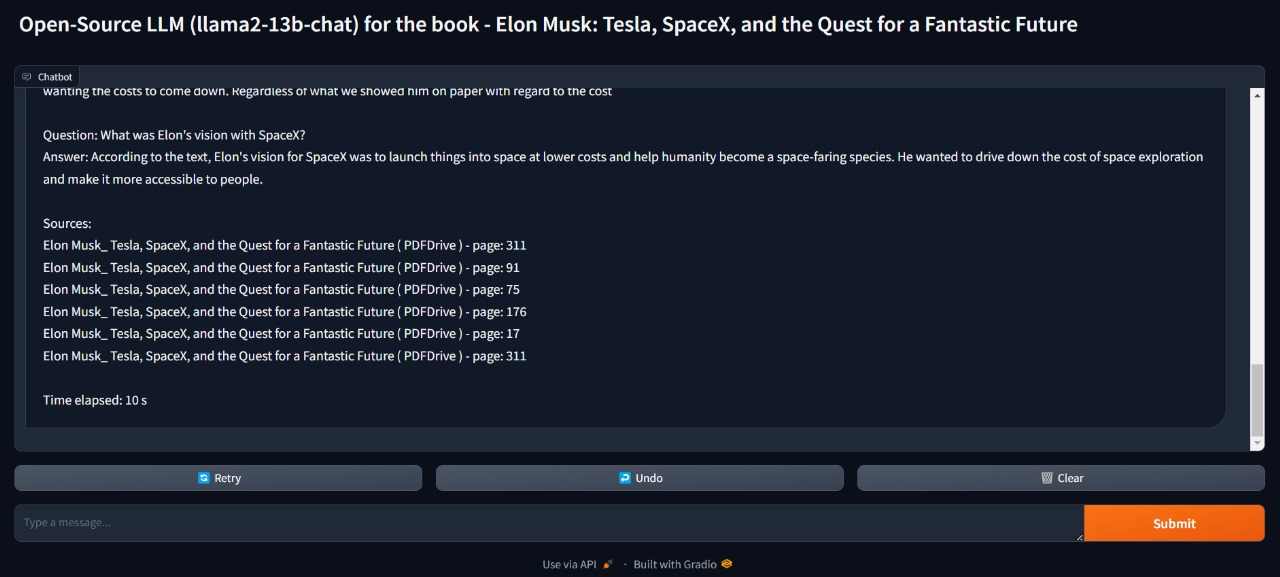

In [ ]:
image_path = '/content/drive/MyDrive/Data_Engineering/Prompt_1.jpg'
from PIL import Image
image = Image.open(image_path)
display(image)

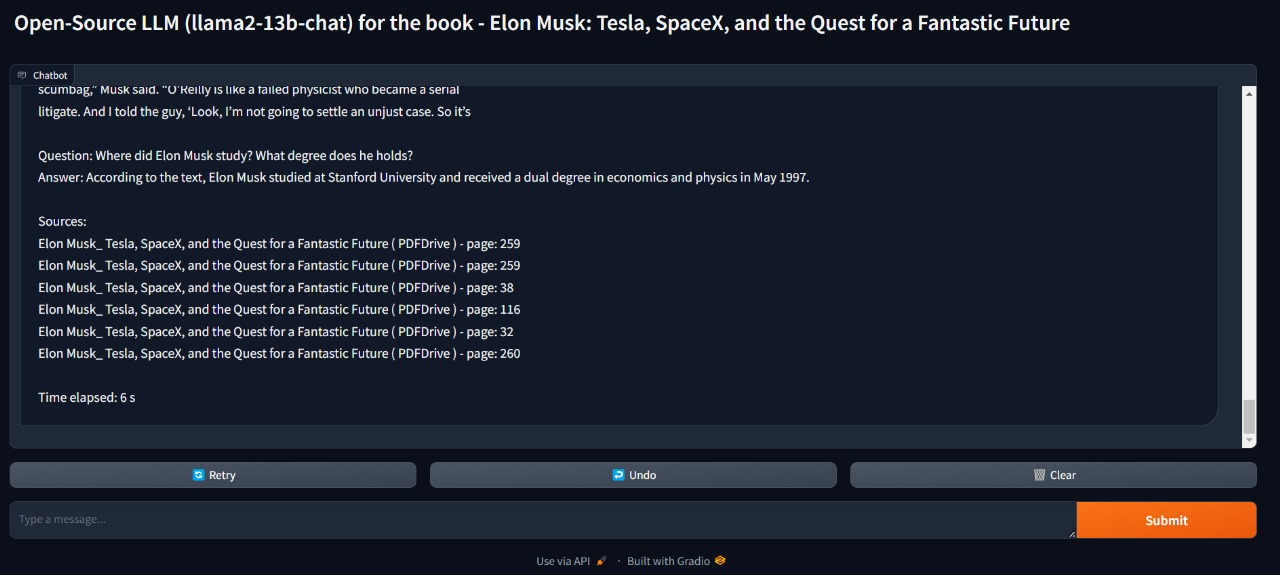

In [ ]:
image_path = '/content/drive/MyDrive/Data_Engineering/Prompt_2.jpg'
from PIL import Image
image = Image.open(image_path)
display(image)

# 10. Exploring Future Prospects and Potential Extensions <a class="anchor" id="Bullet10"></a>

As the project progresses, there are several exciting avenues to explore and enhancements to consider for further development and refinement, extending the application of the chatbot beyond its initial scope. Here are some potential future prospects and extensions:

* Domain-Specific Applications: The chatbot's capabilities can be extended to various domains, including legal, finance, healthcare, and education. By training the model on domain-specific datasets and incorporating relevant knowledge bases, the chatbot can provide specialized assistance and insights tailored to specific industries and professions.
* Novel Understanding and Analysis: Leveraging the chatbot's natural language processing abilities, it can be trained to read and understand novels, analyze themes, characters, and plot structures, and generate summaries or insights to aid readers and literary scholars.
* Information Summarization: The chatbot can be enhanced to automatically analyze and summarize information from lengthy documents, research papers, or news articles. By extracting key concepts, summarizing main points, and condensing content into digestible summaries, the chatbot can facilitate information retrieval and knowledge dissemination.
* Interactive Learning and Education: Incorporating interactive learning features, the chatbot can serve as a virtual tutor or educational assistant, providing explanations, answering questions, and offering personalized learning experiences across various subjects and disciplines.
* Sentiment Analysis and Emotional Support: Integrating sentiment analysis capabilities, the chatbot can recognize and respond to users' emotional cues, offering empathetic responses and providing emotional support in situations such as mental health counseling or customer service interactions.
* Real-Time Language Translation: Expanding the chatbot's functionality to include real-time language translation capabilities can facilitate communication across language barriers, enabling multilingual interactions and fostering cross-cultural understanding.
* Accessibility and Inclusivity: Ensuring accessibility and inclusivity, the chatbot can be designed to accommodate users with disabilities or special needs, offering alternative input methods, voice interfaces, or text-to-speech capabilities to enhance usability and reach a wider audience.

By exploring these diverse applications and extensions, the chatbot can evolve into a versatile and valuable tool, capable of addressing a wide range of user needs and scenarios across different domains and industries. Through continuous innovation and iteration, the chatbot can contribute to improving efficiency, accessibility, and user experiences in various aspects of daily life and professional endeavors.



# 11. Conclusion <a class="anchor" id="Bullet11"></a>


In conclusion, our project has showcased the transformative potential of state-of-the-art techniques like the Retrieval-Augmented Generation (RAG) framework and Large Language Models (LLMs) in advancing conversational AI. RAG's fusion of retrieval and generation approaches has empowered our chatbot to deliver contextually rich responses, drawing from vast knowledge sources. Complemented by LLMs, our chatbot demonstrates enhanced language understanding, enabling it to engage users in nuanced conversations across various domains.

Looking forward, RAG and LLMs promise to reshape conversational AI, offering intelligent chatbots that excel in understanding and generating human-like responses. Whether in education, healthcare, or customer service, these technologies open new horizons for AI applications, enriching user experiences and driving innovation. As we continue to harness the power of RAG and LLMs, we're poised to unlock new frontiers in human-machine interaction, ushering in a future where AI-powered chatbots seamlessly integrate into our lives, offering assistance, insight, and companionship.


# 12. References <a class="anchor" id="Bullet11"></a>

1. huggingface.co. (n.d.). meta-llama/Llama-2-13b-chat-hf · Hugging Face. [online] Available at: https://huggingface.co/meta-llama/Llama-2-13b-chat-hf.
2. huggingface.co. (n.d.). Pipelines. [online] Available at: https://huggingface.co/docs/transformers/en/main_classes/pipelines.
3. www.pdfdrive.com. (n.d.). Elon Musk: Tesla, SpaceX, and the Quest for a Fantastic Future by Ashlee Vance - PDF Drive. [online] Available at: https://www.pdfdrive.com/elon-musk-tesla-spacex-and-the-quest-for-a-fantastic-future-e158582712.html
4. Prabhu (2019). Understanding NLP Word Embeddings — Text Vectorization. [online] Medium. Available at: https://towardsdatascience.com/understanding-nlp-word-embeddings-text-vectorization-1a23744f7223.